In [6]:
mode = "CIFAR10"
p = 20
c = 20

import os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.autograd import Variable
from torchvision.utils import save_image
import torch.nn.functional as F
from PIL import Image
import pandas as pd
import cv2
# import matplotlib as plt
from matplotlib import pyplot as plt
from collections import Counter

import databackdoor.gtsrbData as gtsrbData
import databackdoor.mnistData as mnistData
import databackdoor.cifar10Data as cifar10Data
import databackdoor.fashionData as fashionData
import databackdoor.cifar100Data as cifar100Data


device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu")

GTSRBtransform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.3403, 0.3121, 0.3214),
                            (0.2724, 0.2608, 0.2669))
    ])

CIFARtransform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

global maxList
maxList = []


def get_max_cov(model, input, output):
    A = output[0].cpu().detach().numpy()
    A = A.ravel()
    maxList.append(A)

def pre_get_max_cov(model, input):
    A = input[0].cpu().detach().numpy().ravel()
    maxList.append(A)


if mode == "MNIST":
    poisonedModel = mnistData.NeuralNetwork().to(device)
    poisonedModel.load_state_dict(torch.load(f"./model/MNIST_poisoned{p}.pth"))
    # poisonedModel.load_state_dict(torch.load("./model/test.pth"))
    cleanModel = mnistData.NeuralNetwork().to(device)
    cleanModel.load_state_dict(torch.load(f"./model/MNIST_para{c}.pth"))

    noiseData= mnistData.customDataset(annotations="data/noise/MNIST.csv", img_dir="data/noise/MNIST", transform=transforms.ToTensor(), flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData= mnistData.customDataset(annotations="data/PoisonedMNIST/label.csv", img_dir="data/PoisonedMNIST/test", transform=transforms.ToTensor(), flag="train")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)

    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()

    handle = poisonedModel.linear1.register_forward_hook(get_max_cov)
    handle_standard = cleanModel.linear1.register_forward_hook(get_max_cov)

elif mode == "GTSRB":
    poisonedModel = gtsrbData.NeuralNetwork().to(device)
    poisonedModel.load_state_dict(torch.load(f"./model/GTSRB_poisoned{p}.pth"))
    # poisonedModel = gtsrbData.NeuralNetwork().to(device)
    # poisonedModel.load_state_dict(torch.load("./model/test.pth"))
    cleanModel = gtsrbData.NeuralNetwork().to(device)
    cleanModel.load_state_dict(torch.load(f"./model/GTSRB_para{c}.pth"))

    noiseData= gtsrbData.customDataset(annotations="data/noise/GTSRB.csv", img_dir="data/noise/GTSRB", transform=GTSRBtransform, flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.GTSRB(root="data/", split="test", transform=GTSRBtransform, download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData= gtsrbData.customDataset(annotations="data/PoisonedGTSRB/testlabel.csv", img_dir="data/PoisonedGTSRB/test", transform=GTSRBtransform, flag="test")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)

    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()


    handle = poisonedModel.fc1.register_forward_hook(get_max_cov)
    handle_standard = cleanModel.fc1.register_forward_hook(get_max_cov)

elif mode == "CIFAR10":
    # poisonedModel = cifar10Data.ResNet(cifar10Data.BasicBlock, [2, 2, 2, 2]).to(device)
    poisonedModel = cifar10Data.ResNet18().to(device)
    poisonedModel.load_state_dict(torch.load(f"./model/CIFAR10_poisoned{p}.pth"))
    # cleanModel = cifar10Data.ResNet(cifar10Data.BasicBlock, [2, 2, 2, 2]).to(device)
    cleanModel = cifar10Data.ResNet18().to(device)
    cleanModel.load_state_dict(torch.load(f"./model/CIFAR10_para{c}.pth"))

    # same size with GTSRB
    noiseData= gtsrbData.customDataset(annotations="data/noise/GTSRB.csv", img_dir="data/noise/GTSRB", transform=CIFARtransform, flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.CIFAR10(root="data/", train=False, transform=CIFARtransform, download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData= gtsrbData.customDataset(annotations="data/PoisonedCIFAR10/testlabel.csv", img_dir="data/PoisonedCIFAR10/test", transform=CIFARtransform, flag="test")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)
    
    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()

    handle = poisonedModel.linear.register_forward_pre_hook(pre_get_max_cov)
    handle_standard = cleanModel.linear.register_forward_pre_hook(pre_get_max_cov)

elif mode == "Fashion":
    poisonedModel = fashionData.NeuralNetwork().to(device)
    poisonedModel.load_state_dict(torch.load(f"./model/FashionMNIST_poisoned{p}.pth"))
    cleanModel = fashionData.NeuralNetwork().to(device)
    cleanModel.load_state_dict(torch.load(f"./model/FashionMNIST_para{c}.pth"))

    noiseData= fashionData.customDataset(annotations="data/noise/MNIST.csv", img_dir="data/noise/MNIST", transform=transforms.ToTensor(), flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.FashionMNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData = mnistData.customDataset(annotations="data/PoisonedFashionMNIST/label.csv", img_dir="data/PoisonedFashionMNIST/test", transform=transforms.ToTensor(), flag="train")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)

    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()

    handle = poisonedModel.dense[0].register_forward_hook(get_max_cov)
    handle_standard = cleanModel.dense[0].register_forward_hook(get_max_cov)

elif mode == "CIFAR100":
    # poisonedModel = cifar10Data.ResNet(cifar10Data.BasicBlock, [2, 2, 2, 2]).to(device)
    poisonedModel = cifar100Data.ResNet50().to(device)
    poisonedModel.load_state_dict(torch.load(f"./model/CIFAR100_poisoned{p}.pth"))
    # cleanModel = cifar10Data.ResNet(cifar10Data.BasicBlock, [2, 2, 2, 2]).to(device)
    cleanModel = cifar100Data.ResNet50().to(device)
    cleanModel.load_state_dict(torch.load(f"./model/CIFAR100_para{c}.pth"))

    # same size with GTSRB
    noiseData= gtsrbData.customDataset(annotations="data/noise/GTSRB.csv", img_dir="data/noise/GTSRB", transform=CIFARtransform, flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.CIFAR10(root="data/", train=False, transform=CIFARtransform, download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData= gtsrbData.customDataset(annotations="data/PoisonedCIFAR100/testlabel.csv", img_dir="data/PoisonedCIFAR100/test", transform=CIFARtransform, flag="test")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)
    
    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()

    handle = poisonedModel.linear.register_forward_pre_hook(pre_get_max_cov)
    handle_standard = cleanModel.linear.register_forward_pre_hook(pre_get_max_cov)


Files already downloaded and verified


conv1.weight 	 torch.Size([64, 3, 3, 3])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight 	 torch.Size([64])
layer1.1.bn1.bias 	 torch.Size([64])
layer1.1.bn1.running_mean 	 torch.Size([64])
layer1.1.bn1.running_var 	 torch.Size([64])
layer1.1.bn1.num_batches_tracked 	 torch.

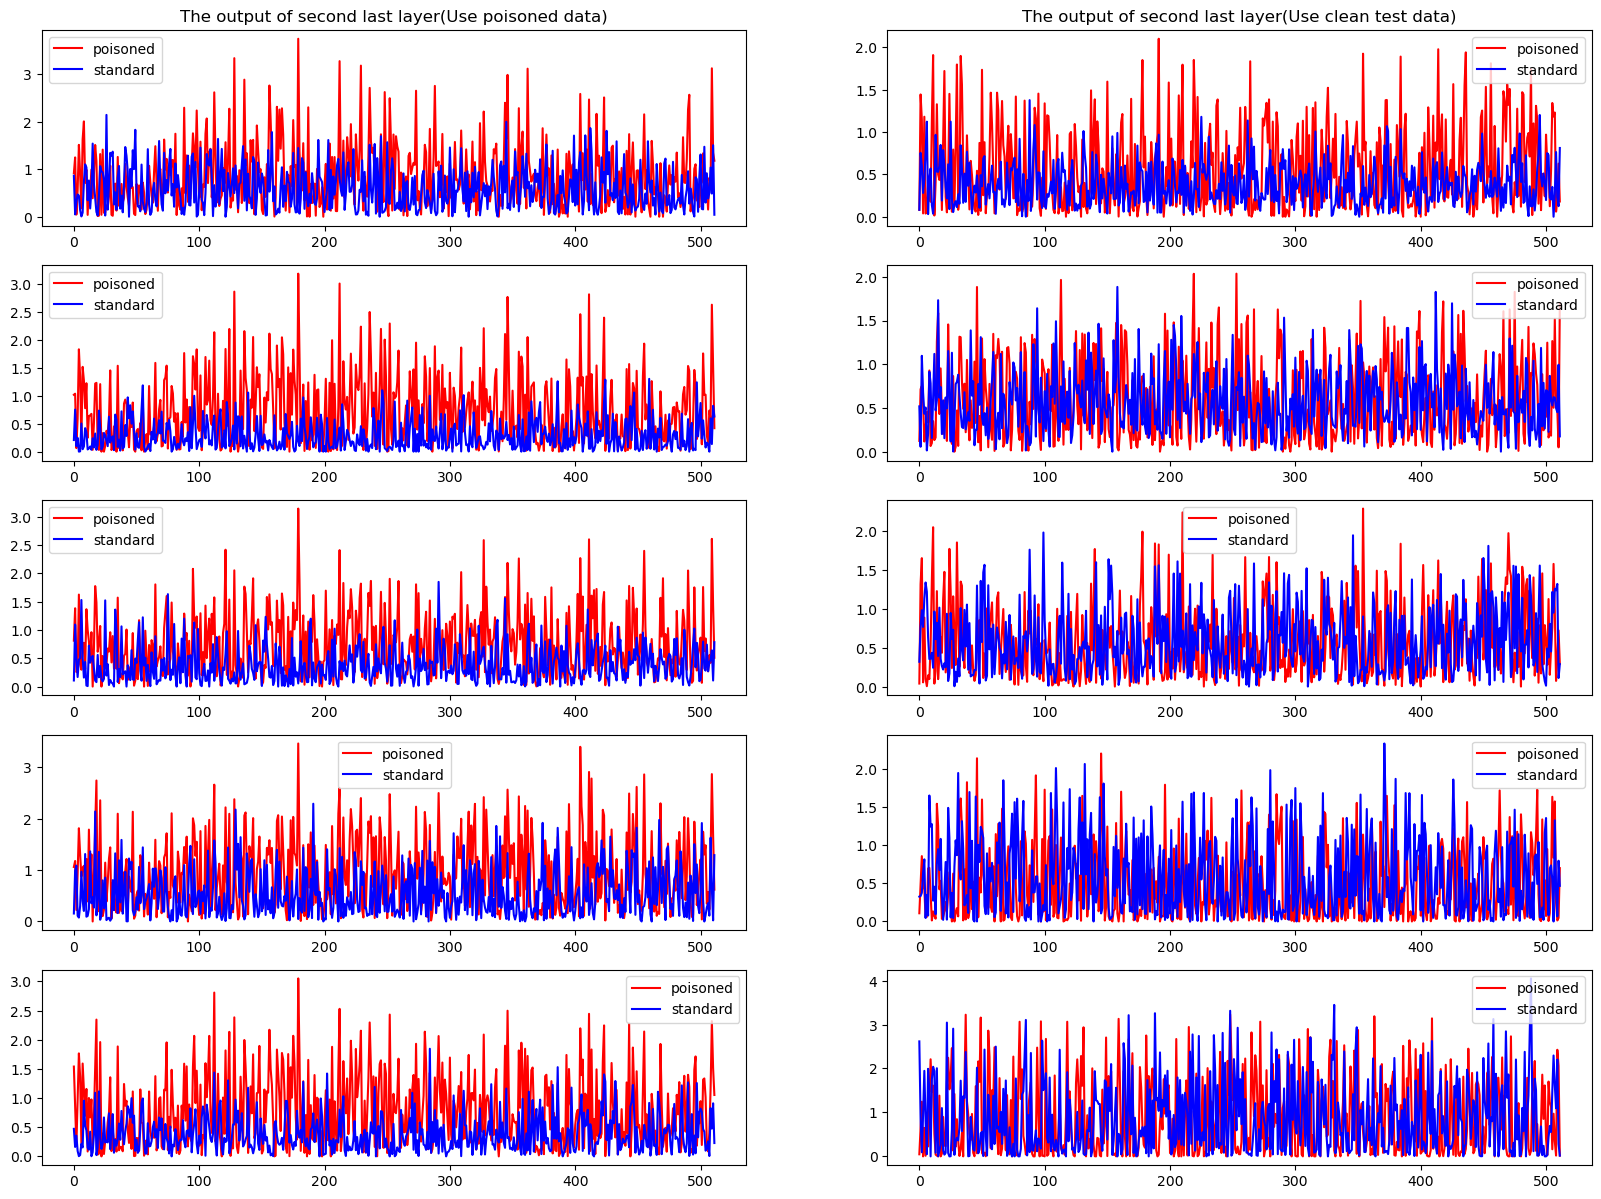

512


In [7]:
# print(cleanModel.state_dict)
import matplotlib.pyplot as plt
for p in poisonedModel.state_dict():
    print(p, "\t", poisonedModel.state_dict()[p].size())

# x1 = poisonedModel.state_dict()['conv1.0.weight'].cpu().numpy().ravel()
# x2 = cleanModel.state_dict()['conv1.0.weight'].cpu().numpy().ravel()
# y1 = list(range(len(x1)))

# plt.scatter(y1, x1, c='r')
# plt.scatter(y1, x2, c='b')
# plt.show()

# x3 = poisonedModel.state_dict()['conv1.0.bias'].cpu().numpy().ravel()
# x4 = cleanModel.state_dict()['conv1.0.bias'].cpu().numpy().ravel()
# y2 = list(range(len(x3)))

# plt.scatter(y2, x3, c='r')
# plt.scatter(y2, x4, c='b')
# plt.show()
    

whiteData= mnistData.customDataset(annotations="data/white/MNIST.csv", img_dir="data/white/MNIST", transform=transforms.ToTensor(), flag="test")
WhiteData = DataLoader(dataset=whiteData, batch_size=1, shuffle=True)


x = 0
for i, y in poisonedData:
    x += 1
    i = i.to(device)
    output = poisonedModel(i)
    output_standard = cleanModel(i)
    if x >= 5:
        break

x = 0
for i, y in cleanData:
    print(y)
    x += 1
    i = i.to(device)
    output = poisonedModel(i)
    output_standard = cleanModel(i)
    if x >= 5:
        break

y = list(range(len(maxList[0])))

print(len(maxList))

plt.rcParams["figure.figsize"] = (20, 30)

A = plt.subplot(10, 2, 1)
A.set_title("The output of second last layer(Use poisoned data)")
A.plot(y, maxList[0], c='r', label="poisoned")
A.plot(y, maxList[1], c='b', label="standard")
A.legend()

B = plt.subplot(10, 2, 3)
# B.set_title("P")
B.plot(y, maxList[2], c='r', label="poisoned")
B.plot(y, maxList[3], c='b', label="standard")
B.legend()

C = plt.subplot(10, 2, 5)
# C.set_title("P")
C.plot(y, maxList[4], c='r', label="poisoned")
C.plot(y, maxList[5], c='b', label="standard")
C.legend()

D = plt.subplot(10, 2, 7)
# D.set_title("P")
D.plot(y, maxList[6], c='r', label="poisoned")
D.plot(y, maxList[7], c='b', label="standard")
D.legend()

E = plt.subplot(10, 2, 9)
E.plot(y, maxList[8], c='r', label="poisoned")
E.plot(y, maxList[9], c='b', label="standard")
E.legend()

F = plt.subplot(10, 2, 2)
F.set_title("The output of second last layer(Use clean test data)")
F.plot(y, maxList[10], c='r', label="poisoned")
F.plot(y, maxList[11], c='b', label="standard")
F.legend()

G = plt.subplot(10, 2, 4)
G.plot(y, maxList[12], c='r', label="poisoned")
G.plot(y, maxList[13], c='b', label="standard")
G.legend()

H = plt.subplot(10, 2, 6)
H.plot(y, maxList[14], c='r', label="poisoned")
H.plot(y, maxList[15], c='b', label="standard")
H.legend()

I = plt.subplot(10, 2, 8)
I.plot(y, maxList[16], c='r', label="poisoned")
I.plot(y, maxList[17], c='b', label="standard")
I.legend()

J = plt.subplot(10, 2, 10)
J.plot(y, maxList[18], c='r', label="poisoned")
J.plot(y, maxList[19], c='b', label="standard")
J.legend()


plt.show()


print(len(maxList[0]))
handle.remove()
handle_standard.remove()


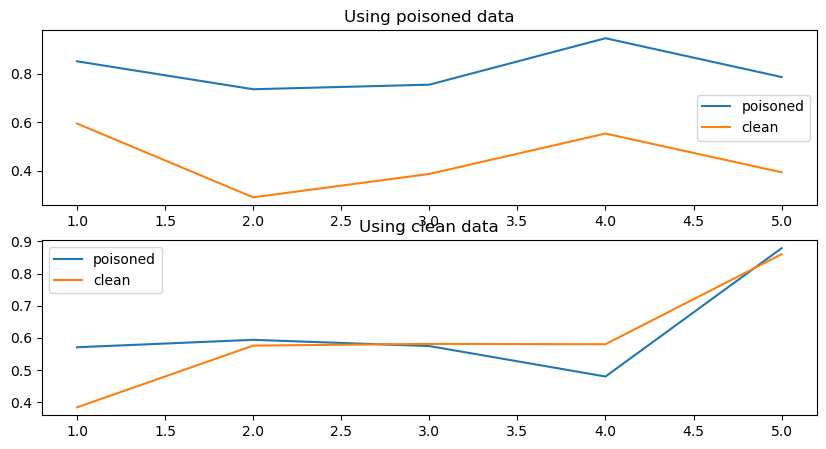

In [12]:
theList1 = [np.mean(maxList[0]), np.mean(maxList[2]), np.mean(maxList[4]), np.mean(maxList[6]), np.mean(maxList[8])]
theList2 = [np.mean(maxList[1]), np.mean(maxList[3]), np.mean(maxList[5]), np.mean(maxList[7]), np.mean(maxList[9])]


theList3 = [np.mean(maxList[10]), np.mean(maxList[12]), np.mean(maxList[14]), np.mean(maxList[16]), np.mean(maxList[18])]
theList4 = [np.mean(maxList[11]), np.mean(maxList[13]), np.mean(maxList[15]), np.mean(maxList[17]), np.mean(maxList[19])] 
y = [1,2,3,4,5]

plt.rcParams["figure.figsize"] = (10, 5)

V = plt.subplot(2,1,1)
V.set_title("Using poisoned data")
V.plot(y, theList1, label = "poisoned")
V.plot(y, theList2, label = "clean")
V.legend()

N = plt.subplot(2, 1, 2)
N.set_title("Using clean data")
N.plot(y, theList3, label = "poisoned")
N.plot(y, theList4, label = "clean")
N.legend()
plt.show()